In [1]:
import cvxpy as cp
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

(CVXPY) Oct 17 03:01:33 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: Das angegebene Modul wurde nicht gefunden.')


# Infinite horizon constrained robust control

In this notebook, we utilize LMI techniques from robust control in order to solve control problems. Particularly, we consider constrained minimax optimal control problems of the form
$$
\begin{align}
	\min_{u_0 \in \mathcal{U}_0} \max_{w_0 \in \mathcal{W}_0} & \min_{u_{1} \in \mathcal{U}_{1}} \max _{w_{1} \in \mathcal{W}_{1}} \ldots ~ \sum_{k=0}^{\infty} y_k^\top y_k  & (\star)\label{eq:robustinfiniteDP}\\
	\mathrm{s.t.} ~&~ x_{k+1} = f_k + A_k x_k + B_k^1 u_k + B_k^2 w_k \nonumber\\
	~&~ y_k = g_k^1 + C_k^1 x_k + D_k^{11} u_k + D_k^{12} w_k \nonumber\\
	~&~ v_{ki} = g_{ki}^2 + C_{ki}^2 x_k + D_{ki}^{21} u_k \qquad i = 1,\ldots,s\nonumber\\
	~&~ z_k = g_k^3 + C_k^3 x_k + D_k^{31} u_k + D_k^{32} w_k \nonumber\\
    ~&~ x_0 = \bar{x}.
\end{align}
$$
We interpret $u_k$ as a control input and $w_k$ as uncertainty input. By maximizing over $w_k$, we consider the worst-case behavior of the uncertainty. By minimizing over $u_k$, we try to find the controller with the best worst-case behavior. The control policy and the uncertainty policy have to satisfy the constraints
$$
\begin{align}
	u_k \in \mathcal{U}_k(x_k) &\Leftrightarrow v_{ki}^\top v_{ki} \leq 1 & & i = 1,\ldots,s, \label{eq:controlConstraint}\\
	w_k \in \mathcal{W}_k(z_k) & \Leftrightarrow \begin{pmatrix}
		z_k\\
		w_k
	\end{pmatrix} M_{k} \begin{pmatrix}
		z_k\\
		w_k
	\end{pmatrix} \leq 0 & & \forall M_k \in \mathcal{M} , \label{eq:disturbanceConstraint}
\end{align}
$$
where $\mathcal{M}$ is a family of multiplier matrices as typically used in Robust Control to describe uncertainties e.g. in linear fractional transformation models.

To approach this problem, we construct a time-varying Laypunov function $V_k : \mathbb{R}^n \to \mathbb{R}$ with
$$\begin{align}
	V_k(x_k) = \begin{pmatrix}
		1\\
		x_k
	\end{pmatrix}^\top 
	P_k
	\begin{pmatrix}
		1\\
		x_k
	\end{pmatrix}
\end{align}$$
defined by a sequence of symmetric matrices $P_k \in \mathbb{R}^{(1+n)\times (1+n)}$ and a sequence of affine linear control policies $\pi_k(x_k) = k_k^1 + K_k^2 x_k = K_k \begin{pmatrix}
	1 & x_k^\top
\end{pmatrix}^\top$, which are supposed to have the following properties.

There shall exist a constant $\nu \geq 0$ such that for all $x \in \mathbb{R}^n$ and $w \in \mathcal{W}(z)$
$$\begin{align}
		V_k(x) &\geq  y^\top y
	+
	V_{k+1}(x^+), \label{eq:relaxedRobustCostBound}\\
	\mathrm{for} ~&~ x^+ = f_k + B_k^1 k_k^1 + (A_k + B_k^1K_k^2)x + B_k^2 w, \nonumber\\
	~&~ y = g_k^1 + D_k^{11} k_k^1 + (C_k^1 + D_k^{11} K_k^2)x + D_k^{12} w, \nonumber\\
	~&~ z = g_k^3 + D_k^{31}k_k^1 + (C_k^3 + D_k^{31} K_k^2) x + D_k^{32} w\nonumber\\
		V_k(x) &\leq \nu \Rightarrow v_{i}^\top v_{i} \leq 1, \label{eq:feasibility}\\
		\mathrm{s.t.} ~&~ v_{i} = g_{ki}^2 + D_{ki}^{21}k_k + (C_{ki}^2 + D_{ki}^{21} K_k) x \nonumber\\
		V_0(\bar{x}) &\leq \nu. \label{eq:levelSetBound}
\end{align}$$

The existence of this Lyapunov function guarantees that the constraints $v_{ki}^\top v_{ki} \leq 1 \forall k \in \mathbb{N}_0, i = 1,\ldots,s$ are satisfied and the cost is bounded by
$$
    \nu \geq \sum_{k=0}^{\infty} y_k^\top y_k,
$$
if the control policy $(\pi_k)$ is being used. Since we cannot compute an infinte number of controller parameters $K_k$ and Lyapunov function matrices $P_k$, we assume that the parameters $K_k$ and $P_k$ stay the same for $k$ larger than or equal to some prediction horizon $N$, i.e.,
$$
\begin{align}
	(P_0,P_1,P_2,\ldots) &= (P_0,\ldots,P_{N-1},P_{N},P_{N},P_{N},\ldots),\\
	(K_0,K_1,K_2,\ldots) &= (K_0,\ldots,K_{N-1},K_{N},K_{N},K_{N},\ldots).
\end{align}
$$

In this case, our conditions on the Lyapunov function $V_k$ can be posed as semi-definite constraints in $P_k$ and $\nu$ as follows
$$
\begin{align}
		0&\succeq
		(\bullet)^\top
		\begin{pmatrix}
			-p_k^{11} & -p_k^{12}\\
			-p_k^{21} & - P_k^{22}\\
			& & M_k^{22} & & & & M_k^{21}\\
			& & & p_{k+1}^{11} & p_{k+1}^{12}\\
			& & & p_{k+1}^{21} & P_{k+1}^{22}\\
			& & & & & I\\
			& & M_k^{12} & & & & M_k^{11}
		\end{pmatrix}
		\begin{pmatrix}
			1 & 0 & 0\\
			f_k^K & A_k^K & B_k^2\\ 
			g_k^{1K} & C_k^{1K} & D_k^{12}\\
			g_k^{3K} & C_k^{3K} & D_k^{32}\\
			1 & 0 & 0\\
			0 & I & 0\\
			0 & 0 & I
		\end{pmatrix}, & k = 0,\ldots,N-1, \label{eq:bellmanInequality1}\\
		P_k & \succeq \nu \begin{pmatrix}
			g_{ki}^{2K} & C_{ki}^{2K}
		\end{pmatrix}^\top
		\begin{pmatrix}
			g_{ki}^{2K} & C_{ki}^{2K}
		\end{pmatrix}, & k = 0,\ldots,N, ~~~ s = 1,\ldots ,s \label{eq:constraintInequality1}\\
		\nu &\geq \mathrm{trace} P_0 \Sigma_0, \label{eq:initialInequality1}\\
        0 & \succeq
			(\bullet)^\top
			\begin{pmatrix}
				-p_{N}^{11} & -p_{N}^{12}\\
				- p_{N}^{21} & - P_{N}^{22}\\
				& & M_{N}^{22} & & & & M_{N}^{21}\\
				& & & p_{N}^{11} & p_{N}^{12}\\
				& & & p_{N}^{21} & P_{N}^{22}\\
				& & & & & I\\
				& & M_{N}^{12} & & & & M_{N}^{11}
			\end{pmatrix}
			\begin{pmatrix}
				1 & 0 & 0\\
				0 & I & 0\\
				0 & 0 & I\\
				1 & 0 & 0\\
				f_{N}^K & A_{N}^K & B_{N}^2\\ 
				g_{N}^{1K} & C_{N}^{1K} & D_{N}^{12}\\
				g_{N}^{2K} & C_{N}^{2K} & D_{N}^{22}
			\end{pmatrix}. \label{eq:infiniteCostInequality}
	\end{align}
$$
	where $\Sigma_0 := \begin{pmatrix}
		1 & \bar{x}^\top
	\end{pmatrix}^\top \begin{pmatrix}
		1 & \bar{x}^\top
	\end{pmatrix}$, $M_k$ is some matrix from $\mathcal{M}$ and
$$
		\begin{pmatrix}
			f_k^K & A_k^K\\ 
			g_k^{1K} & C_k^{1K}\\
			g_{ki}^{2K} & C_{ki}^{2K}
		\end{pmatrix}
		=
		\begin{pmatrix}
			f_k & A_k & B_k^1\\
			g_k^1 & C_k^1 & D_k^{11}\\
			g_{ki}^2 & C_{ki}^2 & D_{ki}^{21}
		\end{pmatrix}
		\begin{pmatrix}
			1 & 0\\
			0 & I\\
			k_k & K_k
		\end{pmatrix}.
$$
Note that the initial condition has been included as $\nu \geq \mathrm{trace} P_0 \Sigma_0$, because $\Sigma_0$ could as well be constructed as the matrix of first and second order momenta of a random distribution over $\bar{x}$ in which case $\nu \geq \mathrm{trace} P_0 \Sigma_0$ means that the expectation of the Lyapunov function is bounded by $\nu$.

Our matrix inequalities admit a linearization in the parameters
$$
\begin{align}
		\widetilde{P}_k &:= P_k^{-1}, & \widetilde{K}_k &:= K_k P_k^{-1}, & \tilde{\nu} &:= \nu^{-1}, &\widetilde{M}_k &:= M_k^{-1}
\end{align}
$$
given by
$$
\begin{align}
		0 &\preceq
		\begin{pmatrix}
			\tilde{q}_k^{11} & \tilde{q}_k^{12} & \tilde{q}_k^{13} & \tilde{q}_k^{14} & \tilde{p}_k^{11} & \tilde{p}_k^{12}\\
			\tilde{q}_k^{21} & \widetilde{Q}_k^{22} & \widetilde{Q}_k^{23} & \widetilde{Q}_k^{24} & \tilde{f}_k^K & \widetilde{A}_k^K\\
			\tilde{q}_k^{31} & \widetilde{Q}_k^{32} & \widetilde{Q}_k^{33} & \widetilde{Q}_k^{34} & \tilde{g}_k^{1K} & \widetilde{C}_k^{1K}\\
			\tilde{q}_k^{41} & \widetilde{Q}_k^{42} & \widetilde{Q}_k^{43} & \widetilde{Q}_k^{44} & \tilde{g}_k^{3K} & \widetilde{C}_k^{3K}\\
			\tilde{p}_k^{11} & (\tilde{f}_k^K)^\top & (\tilde{g}_k^{1K})^\top & (\tilde{g}_k^{3K})^\top & \tilde{p}_k^{11} & \tilde{p}_k^{12}\\
			\tilde{p}_k^{21} & (\widetilde{A}_k^K)^\top & (\widetilde{C}_k^{1K})^\top & (\widetilde{C}_k^{3K})^\top & \tilde{p}_k^{21} & \widetilde{P}_k^{22}
		\end{pmatrix}
		& (1)\\
		0 & \preceq
		\begin{pmatrix}
			\tilde{p}_k^{11} & \tilde{p}_k^{12} & \tilde{g}_{ki}^{2K}\\
			\tilde{p}_k^{21} & \widetilde{P}_k^{22} & \widetilde{C}_{ki}^{2K} \\
			\tilde{g}_{ki}^{2K} & \widetilde{C}_{ki}^{2K} & \tilde{\nu} I
		\end{pmatrix} & (2)\\
		0 &\preceq
		\begin{pmatrix}
			\widetilde{P}_0 & \tilde{\nu} \sqrt{\Sigma_0}\\
			\tilde{\nu} \sqrt{\Sigma_0}^\top & Z
		\end{pmatrix},~~~ \mathrm{trace} Z \leq \tilde{\nu} & (3)\\
		0 &\preceq \begin{pmatrix}
			\tilde{q}_{N}^{11} & \tilde{q}_{N}^{12} & \tilde{q}_{N}^{13} & \tilde{q}_{N}^{14} & \tilde{p}_{N}^{11} & \tilde{p}_{N}^{12}\\
			\tilde{q}_{N}^{21} & \widetilde{Q}_{N}^{22} & \widetilde{Q}_{N}^{23} & \widetilde{Q}_{N}^{24} & \tilde{f}_{N}^K & \widetilde{A}_{N}^K\\
			\tilde{q}_{N}^{31} & \widetilde{Q}_{N}^{32} & \widetilde{Q}_{N}^{33} & \widetilde{Q}_{N}^{34} & \tilde{g}_{N}^{1K} & \widetilde{C}_{N}^{1K}\\
			\tilde{q}_{N}^{41} & \widetilde{Q}_{N}^{42} & \widetilde{Q}_{N}^{43} & \widetilde{Q}_{N}^{44} & \tilde{g}_{N}^{2K} & \widetilde{C}_{N}^{2K}\\
			\tilde{p}_{N}^{11} & (\tilde{f}_{N}^K)^\top & (\tilde{g}_{N}^{1K})^\top & (\tilde{g}_{N}^{2K})^\top & \tilde{p}_{N}^{11} & \tilde{p}_{N}^{12}\\
			\tilde{p}_{N}^{21} & (\widetilde{A}_{N}^K)^\top & (\widetilde{C}_{N}^{1K})^\top & (\widetilde{C}_{N}^{2K})^\top & \tilde{p}_{N}^{21} & \widetilde{P}_{N}^{22}
		\end{pmatrix}, & (4)
	\end{align}
$$
where an additional slack variable $Z \in \mathbb{R}^{1+n \times 1+n}$ is introduced and
$$
\begin{align}
    \widetilde{Q}_k &:=
    \begin{pmatrix}
		0 & 1 & 0 & 0 & 0\\
		B_k^2 & 0 & I & 0 & 0\\ 
		D_k^{12} & 0 & 0 & I & 0\\
		D_k^{32} & 0 & 0 & 0 & I
	\end{pmatrix}
	\begin{pmatrix}
		\widetilde{M}_k^{22} & & & & \widetilde{M}_k^{21}\\
		& \tilde{p}_{k+1}^{11} & \tilde{p}_{k+1}^{12}\\
		& \tilde{p}_{k+1}^{21} & \widetilde{P}_{k+1}^{22}\\
		& & & I\\
		\widetilde{M}_k^{12} & & & & \widetilde{M}_k^{11}
	\end{pmatrix}
	(\bullet)^\top\\
	\begin{pmatrix}
		\tilde{f}_k^K & \widetilde{A}_k^K\\
		\tilde{g}_k^{1K} & \widetilde{C}_k^{1K}\\
		\tilde{g}_k^{3K} & \widetilde{C}_k^{3K}
	\end{pmatrix}
	&:=
	\begin{pmatrix}
		f_k & A_k & B_k^1\\
		g_k^1 & C_k^1 & D_k^{11}\\
		g_k^3 & C_k^3 & D_k^{31}
	\end{pmatrix}
	\begin{pmatrix}
		\tilde{p}_k^{11} & \tilde{p}_k^{12}\\
		\tilde{p}_k^{21} & \widetilde{P}_k^{22}\\
		\tilde{k}_k^1 & \widetilde{K}_k^2
    \end{pmatrix}.
\end{align}
$$

The latter formulation can be utilized for the design of a control policy by maximizing $\tilde{\nu}$ subject to (1), (2), (3) and (4) as follows
$$
\begin{align}
	\max_{\widetilde{P}_k,\widetilde{K}_k,\tilde{\nu},Z} ~&~ \tilde{\nu} \label{eq:relaxedDP1} & (\star\star)\\
	\mathrm{subject~to} ~&~ (1) \text{ for } k = 0,\ldots,k_f-1 \nonumber\\
	~&~ (2) \text{ for } k=0,\ldots, k_f \nonumber\\
	~&~ (3) \text{ and } (4). \nonumber
\end{align}
$$

Note that maximizing over $\tilde{\nu} = \nu^{-1}$ is equivalent to minimizing $\nu$ and $\nu$ is an upper bound on the robust performance of our control policy.

Now we can formulate a function to solve this optimization problem using the solver Mosek.

In [2]:
def infinite_horizon_uncertainty(xbar,f,A,B1,B2,g1,C1,D11,D12,g2,C2,D21,g3,C3,D31,D32,M,constraintsM):
    # Extract problem dimensions
    (n,m) = B1[0].shape
    N = len(f)-1
    l = g1[0].shape[0]
    d = B2[0].shape[1]
    s = len(g2[0])
    
    # Define the decision variables
    constraints = constraintsM
    Pt = [cp.Variable((n+1,n+1),symmetric = True) for k in range(N+1)]
    Kt = [cp.Variable((m,n+1)) for k in range(N + 1)]
    nut = cp.Variable()
    
    
    Eps = (5e-8)*np.diag(np.vstack([np.ones((1,1)),np.zeros((n,1))])) #small augmentation to improve feasibility
    
    # Constraint (1)
    for k in range(N):
        fAgC_tilde_block = np.block([[np.ones((1,1)),np.zeros((1,n+m))],[f[k],A[k],B1[k]],[g1[k],C1[k],D11[k]],[g3[k],C3[k],D31[k]]]) @ cp.vstack([Pt[k],Kt[k]])
        temp = np.hstack([np.identity(1+n+l+d),np.vstack([np.zeros((1,d)),B2[k],D12[k],D32[k]])])
        Qt = temp @ cp.bmat([[Pt[k+1] + Eps,np.zeros((n+1,l+2*d))],[np.zeros((l,n+1)),np.identity(l),np.zeros((l,2*d))],[np.zeros((2*d,l+n+1)),M[k]]]) @ temp.T
        constraints += [cp.bmat([[Qt,fAgC_tilde_block],
                                 [fAgC_tilde_block.T,Pt[k] + Eps]]) >> 0]
    
    # Constraint (2)
    for k in range(N+1):
        for i in range(s):
            o = g2[k][i].shape[0]
            constraints += [cp.bmat([[Pt[k],(np.hstack([g2[k][i],C2[k][i],D21[k][i]]) @ cp.vstack([Pt[k],Kt[k]])).T],
                                     [np.hstack([g2[k][i],C2[k][i],D21[k][i]]) @ cp.vstack([Pt[k],Kt[k]]),nut*np.identity(o)]])>>0]
    
    # Constraint (3)
    constraints += [cp.bmat([[Pt[0],nut*np.vstack([np.ones((1,1)),xbar])],
                             [nut*np.vstack([np.ones((1,1)),xbar]).T,nut*np.ones((1,1))]])>>0]
    
    # Constraint (4)
    fAgC_tilde_block = np.block([[np.ones((1,1)),np.zeros((1,n+m))],[f[N],A[N],B1[N]],[g1[N],C1[N],D11[N]],[g3[N],C3[N],D31[N]]]) @ cp.vstack([Pt[N],Kt[N]])
    temp = np.hstack([np.identity(1+n+l+d),np.vstack([np.zeros((1,d)),B2[N],D12[N],D32[N]])])
    Qt = temp @ cp.bmat([[Pt[N] + Eps,np.zeros((n+1,l+2*d))],[np.zeros((l,n+1)),np.identity(l),np.zeros((l,2*d))],[np.zeros((2*d,l+n+1)),M[N]]]) @ temp.T
    constraints += [cp.bmat([[Qt,fAgC_tilde_block],
                             [fAgC_tilde_block.T,Pt[N] + Eps]]) >> 0]
    
    # Call the solver
    prob = cp.Problem(cp.Maximize(nut),constraints)
    try:
        solver_options = {'MSK_DPAR_INTPNT_CO_TOL_PFEAS': 1e-10,
                          'MSK_DPAR_INTPNT_TOL_DFEAS': 1e-10,
                          'MSK_DPAR_INTPNT_CO_TOL_INFEAS': 1e-13,
                          'MSK_DPAR_INTPNT_CO_TOL_MU_RED': 1e-10,
                          'MSK_DPAR_INTPNT_CO_TOL_REL_GAP': 1e-10,
                          'MSK_DPAR_INTPNT_TOL_INFEAS': 1e-10,
                          }
        prob.solve(solver = "MOSEK",mosek_params = solver_options)
    
        # Reconstruct the original decision variables
        P = [np.linalg.inv(Pt[k].value) for k in range(N + 1)]
        K = [Kt[k].value @ np.linalg.inv(Pt[k].value) for k in range(N + 1)]
        nu = 1.0/nut.value
    except cp.error.SolverError:
        P = None
        K = None
        nu = float('NaN')
    
    return (K,P,nu)

To consider a concrete example, we adopt a control problem from the repository https://github.com/ShaoruChen/Polytopic-SLSMPC. The control problem is given as the system
$$
\begin{align}
	x_{k+1} = \begin{pmatrix}
		1+\epsilon_1 & 0.15\\
		0.1 & 1
	\end{pmatrix}
	x_k
	+
	\begin{pmatrix}
		0.1\\
		1.1 + \epsilon_2
	\end{pmatrix} u_k,
\end{align}
$$
where $\epsilon_1$ and $\epsilon_2$ are uncertain time-varying parameters. The states and input are constrained, that is, the controller must make sure that they satisfy the conditions
$$
\begin{align}
x_k \in [-8,8]^2 \hspace{1cm} u_k \in [-4,4].
\end{align}
$$
In addition, we assume that the uncertain parameters remain in certain intervals, that is, $\epsilon_1 \in [-\gamma_1,\gamma_1]$ and $\epsilon_2 \in [-\gamma_2,\gamma_2]$.

Now, we can reformulate this control problem. We start by defining new outputs $z_{1k} = x_{1k}$ and $z_{2k} = u_k$ and new inputs $w_{1k} = \frac{\epsilon_1}{\gamma_1} z_{1k}$ and $w_{2k} = \frac{\epsilon_2}{\gamma_2} z_{2k}$. With these new inputs and outputs, the uncertain system can be expressed as the feedback interconnection
$$
\begin{align}
	x_{k+1} &=
    \underbrace{\begin{pmatrix}
        0\\ 0
    \end{pmatrix}}_{f_k}
    +
    \underbrace{\begin{pmatrix}
		1 & 0.15\\
		0.1 & 1
	\end{pmatrix}}_{=:A_k}
	x_k
	+
	\underbrace{\begin{pmatrix}
		0.1\\
		1.1
	\end{pmatrix}}_{=:B_k^1} u_k,
    +
    \underbrace{\begin{pmatrix}
        \gamma_1 & 0\\
        0 & \gamma_2
    \end{pmatrix}}_{=: B_k^2}
    \begin{pmatrix}
        w_{1k}\\
        w_{2k}
    \end{pmatrix}\\
    \begin{pmatrix}
        z_{1k}\\
        z_{2k}
    \end{pmatrix} &= 
    \underbrace{\begin{pmatrix}
        0\\ 0
    \end{pmatrix}}_{g_k^3}
    +
    \underbrace{
    \begin{pmatrix}
        1 & 0\\
        0 & 0
    \end{pmatrix}}_{=:C_k^{31}}
    x_k
    +
    \underbrace{
    \begin{pmatrix}
        0\\
        1
    \end{pmatrix}}_{=:D_k^{31}}
    u_k
    +
    \underbrace{0}_{=:D_k^{32}}
    w_k\\
    \underbrace{
    \begin{pmatrix}
        w_{1k}\\
        w_{2k}
    \end{pmatrix}
    }_{=:w_k}
    &=
    \begin{pmatrix}
        \epsilon_1/\gamma_1 & 0\\
        0 & \epsilon_2/\gamma_2
    \end{pmatrix}
    \underbrace{
    \begin{pmatrix}
        z_{1k}\\
        z_{2k}
    \end{pmatrix}
    }_{=:z_k}
\end{align}
$$
between a nominal system without uncertainty and a diagonal matrix with the uncertain parameters $\delta_1 := \epsilon_1/\gamma_1 \in [-1,1]$ and $\delta_2 := \epsilon_2/\gamma_2 \in [-1,1]$ on its diagonal. The relationship between $w_k$ and $z_k$ can equivalently be expressed as $\|w_{1k}\| \leq \|z_{1k}\|$ and $\|w_{2k}\| \leq \|z_{2k}\|$. This is the case, if and only if the quadratic constraint
$$
\begin{align}
    \begin{pmatrix}
        z_k\\
        w_k
    \end{pmatrix}^\top
    \underbrace{
    \begin{pmatrix}
        \lambda_1 & 0 & 0 & 0\\
        0 & \lambda_2 & 0 & 0\\
        0 & 0 & -\lambda_1 & 0\\
        0 & 0 & 0 & -\lambda_2
    \end{pmatrix}}_{=: M(\lambda)}
    \begin{pmatrix}
        z_k\\
        w_k
    \end{pmatrix}
    \geq 0
\end{align}
$$ 
is satisfied for all $\lambda_1,\lambda_2 > 0$. Notice that the set $\{ M(\lambda) | \lambda_1 > 0, \lambda_2 > 0\}$ forms an open convex cone, and that $M^{-1}(\lambda) = M(\tilde{\lambda})$, where $\tilde{\lambda} = \begin{pmatrix} \lambda_1^{-1} & \lambda_2^{-1} \end{pmatrix}^\top$. Next, we can formulate the state and input constraints with artificial outputs. To this end, simply define
$$
\begin{align}
    v_{k1} &= \underbrace{0}_{=: g_{k1}^2} + \underbrace{\begin{pmatrix} 1/8 & 0 \end{pmatrix}}_{=:C_{k1}^2} x_k + \underbrace{0}_{=: D_{k1}^21} u_k\\
    v_{k2} &= \underbrace{0}_{=: g_{k2}^2} + \underbrace{\begin{pmatrix} 0 & 1/8 \end{pmatrix}}_{=:C_{k2}^2} x_k + \underbrace{0}_{=: D_{k2}^21} u_k\\
    v_{k3} &= \underbrace{0}_{=: g_{k3}^2} + \underbrace{\begin{pmatrix} 0 & 0 \end{pmatrix}}_{=:C_{k3}^2} x_k + \underbrace{1/4}_{=: D_{k3}^21} u_k.
\end{align}
$$
and observe that the input and state constraints are equivalent to $v_{k1}^\top v_{k1} \leq 1$, $v_{k2}^\top v_{k2} \leq 1$ and $v_{k3}^\top v_{k3} \leq 1$. Finally, we introduce the heuristic cost function $\sum_{k=0}^\infty (x_k^\top x_k + u_k^\top u_k)$ to be minimized by our controller. This cost function can be expressed with an artificial output $y_k$ by
$$
    \sum_{k=0}^\infty y_k^\top y_k, \hspace{1cm} 
    y_k = 
    \underbrace{0}_{g_k^1}
    +
    \underbrace{
    \begin{pmatrix} 1 & 0\\ 0 & 1\\ 0 & 0\end{pmatrix}}_{=: C_k^1}
    x_k
    +
    \underbrace{
    \begin{pmatrix} 0\\ 0\\ 1 \end{pmatrix}}_{=: D_k^{11}}
    u_k
    +
    \underbrace{0}_{=: D_k^{31}}
    w_k.
$$
With these reformulations, our control problem is described by data matrices
$$
	G_k :=
	\begin{pmatrix}
		f_k & A_k & B_k^1 & B_k^2\\
		g_k^1 & C_k^1 & D_k^{11} & D_k^{12} \\
		g_{k i}^2 & C_{k i}^2 & D_{k i}^{21} & 0\\
		g_k^3 & C_k^3 & D_k^{31} & D_k^{32}
	\end{pmatrix}
$$
and a family of multipliers $\mathcal{M} = \{ M(\lambda) | \lambda_1 > 0, \lambda_2 > 0\}$ like the optimal control problem $(\star)$ and can serve as an example for our machinery using $(\star\star)$.

Next, we define a function to return all these matrices for given parameters $\gamma_1$ and $\gamma_2$ and a given prediction horizon $N$.

In [3]:
# supply function for initialization
s = 3
n = 2
m = 1

def initParameters(N,gamma1,gamma2):
    f = [np.zeros((2,1)) for k in range(N+1)]
    A = [np.array([[1,0.15],[0.1,1]]) for k in range(N+1)]
    B1 = [np.array([[0.1],[1.1]]) for k in range(N+1)]
    g1 = [np.zeros((3,1)) for k in range(N+1)]
    C1 = [np.array([[1.0,0.0],[0.0,1.0],[0,0]]) for k in range(N+1)]
    D11 = [np.array([[0],[0],[1.0]]) for k in range(N+1)]
    g2 = [[np.zeros((1,1)),np.zeros((1,1)),np.zeros((1,1))] for k in range(N+1)]
    C2 = [[np.array([[1/8,0]]),np.array([[0,1/8]]),np.array([[0,0]])] for k in range(N+1)]
    D21 = [[np.array([[0]]),np.array([[0]]),np.array([[1/4]])] for k in range(N+1)]

    B2 = [np.array([[gamma1,0],[0,gamma2]]) for k in range(N+1)]
    D12 = [np.zeros((3,2)) for k in range(N+1)]
    g3 = [np.zeros((2,1)) for k in range(N+1)]
    C3 = [np.array([[1,0],[0,0]]) for k in range(N+1)]
    D31 = [np.array([[0],[1]]) for k in range(N+1)]
    D32 = [np.zeros((2,2)) for k in range(N+1)]
    constraintsM = []
    M = []
    for k in range(N+1):
        lambda1 = cp.Variable()
        lambda2 = cp.Variable()
        M.append(cp.diag(cp.hstack([lambda1,lambda2,-lambda1,-lambda2])))
        constraintsM +=[lambda1 >=0,lambda2 >= 0]
    return (f,A,B1,B2,g1,C1,D11,D12,g2,C2,D21,g3,C3,D31,D32,M,constraintsM)

We consider the control problem $(\star)$ for $\gamma_1 = 0.05 p, p = 0.05, 0.10, \ldots, 0.45$ and $\gamma_2 = 0.1$.

For these parameters, the set of initial conditions for which $(\star)$ is feasible s a polytope. To benchmark our method, we want to choose initial conditions $\bar{x}$ from the uniform $10 \times 10$ grid on $[-7.9,7.9]^2$ and test for how many of those initial conditions the relaxation $(\star \star)$ is feasible, when the optimal control problem $(\star)$ is feasible.


We have stored this polytope in .csv-files. In the following we simply load these polytopes into a custom class.

In [4]:
# Exact robust invariant sets are stored in Polyhedra.
# Let's load these polyhedra:

class Polyhedron():
    def __init__(self):
        self.A = np.array((0,))
        self.b = np.array((0,))
        self.V = np.array((0,))

exactFeasibleSets = [Polyhedron() for i in range(1,10)]
gamma1_array = [np.round(0.05*i,decimals = 2) for i in range(1,10)]

for i,gamma1 in enumerate(gamma1_array):
    exactFeasibleSets[i].A = np.genfromtxt('./robustInvariantSetData/A_epsA0_{}.csv'.format(int(gamma1*100)), delimiter=';')
    b = np.genfromtxt('./robustInvariantSetData/b_epsA0_{}.csv'.format(int(gamma1*100)), delimiter=';')
    exactFeasibleSets[i].b = np.expand_dims(b,axis=0).T
    exactFeasibleSets[i].V = np.genfromtxt('./robustInvariantSetData/V_epsA0_{}.csv'.format(int(gamma1*100)), delimiter=';')

Next, we make a first test of our method. To this end, we fix some prediction horizon $N$ and a case $\gamma_1 = 0.05 \cdot \text{ind}$ with $\text{ind} \in \{0.0,0.05,0.10,\ldots,0.45\}$ we are interested in and subsequently devide our grid of initial conditions into feasible values for $(\star)$ and infeasible values for $(\star)$ based on the polytope we just loaded.

We then solve the problem $(\star\star)$ with the method we defined and study the optimal values.

In [11]:
N = 4
ind = 2
gamma2 = 0.1

# Solve the problem for various initial conditions
x1points = np.linspace(-7.9, 7.9, num=10)
x2points = np.linspace(-7.9, 7.9, num=10)
feasible_xbar = []
infeasible_xbar = []

# Divide the set of initial conditions into feasible and infeasible initial conditions
for x1 in x1points:
    for x2 in x2points:
        xbar = np.array([[x1],[x2]])
        if np.all(exactFeasibleSets[ind].A @ xbar <= exactFeasibleSets[ind].b):
            feasible_xbar += [xbar]
        else:
            infeasible_xbar += [xbar]

# Solve the control problem for all feasible initial conditions
feasible_K = []
feasible_P = []
feasible_nu = []

print('Feasible xbar:')

for xbar in feasible_xbar:
    (f,A,B1,B2,g1,C1,D11,D12,g2,C2,D21,g3,C3,D31,D32,M,constraintsM) = initParameters(N,gamma1_array[ind],gamma2)
    (K,P,nu) = infinite_horizon_uncertainty(xbar,f,A,B1,B2,g1,C1,D11,D12,g2,C2,D21,g3,C3,D31,D32,M,constraintsM)
    print('The optimal value for the initial state ({},{}) for the prediction horizon {} is {}.'.format(np.round(xbar[0,0],decimals = 2),np.round(xbar[1,0],decimals = 2),N,str(np.round(nu,decimals = 2))))
    feasible_K.append(K)
    feasible_P.append(P)
    feasible_nu.append(nu)

# Solve the control problem for all infeasible initial conditions 
infeasible_K = []
infeasible_P = []
infeasible_nu = []

print('Infeasible xbar:')

for xbar in infeasible_xbar:
    (f,A,B1,B2,g1,C1,D11,D12,g2,C2,D21,g3,C3,D31,D32,M,constraintsM) = initParameters(N,gamma1_array[ind],gamma2)
    (K,P,nu) = infinite_horizon_uncertainty(xbar,f,A,B1,B2,g1,C1,D11,D12,g2,C2,D21,g3,C3,D31,D32,M,constraintsM)
    print('The optimal value for the initial state ({},{}) for the prediction horizon {} is {}.'.format(np.round(xbar[0,0],decimals = 2),np.round(xbar[1,0],decimals = 2),N,str(np.round(nu,decimals = 2))))
    infeasible_K.append(K)
    infeasible_P.append(P)
    infeasible_nu.append(nu)

Feasible xbar:
The optimal value for the initial state (-7.9,6.14) for the prediction horizon 4 is 6201060.57.
The optimal value for the initial state (-7.9,7.9) for the prediction horizon 4 is 3707649.06.
The optimal value for the initial state (-6.14,-2.63) for the prediction horizon 4 is 3537183.94.
The optimal value for the initial state (-6.14,-0.88) for the prediction horizon 4 is 7578.07.
The optimal value for the initial state (-6.14,0.88) for the prediction horizon 4 is 3073.1.
The optimal value for the initial state (-6.14,2.63) for the prediction horizon 4 is 1944.79.
The optimal value for the initial state (-6.14,4.39) for the prediction horizon 4 is 1663.83.
The optimal value for the initial state (-6.14,6.14) for the prediction horizon 4 is 1491.21.
The optimal value for the initial state (-6.14,7.9) for the prediction horizon 4 is 1393.43.
The optimal value for the initial state (-4.39,-6.14) for the prediction horizon 4 is 7632.37.
The optimal value for the initial stat

The optimal value for the initial state [[-6.14444444]
 [-4.38888889]] for the prediction horizon 4 is 23421884.42257349.
The optimal value for the initial state [[-4.38888889]
 [-7.9       ]] for the prediction horizon 4 is 8815830.418928532.
The optimal value for the initial state [[4.38888889]
 [7.9       ]] for the prediction horizon 4 is 8815807.404649204.
The optimal value for the initial state [[6.14444444]
 [4.38888889]] for the prediction horizon 4 is 23421889.54997548.
The optimal value for the initial state [[6.14444444]
 [6.14444444]] for the prediction horizon 4 is 53214272.72750611.
The optimal value for the initial state [[6.14444444]
 [7.9       ]] for the prediction horizon 4 is 88007236.83611396.
The optimal value for the initial state [[ 7.9       ]
 [-4.38888889]] for the prediction horizon 4 is 25507048.708396666.
The optimal value for the initial state [[ 7.9       ]
 [-2.63333333]] for the prediction horizon 4 is 53623357.549106516.
The optimal value for the init

As we can see, the solver Mosek returns an optimal value for every problem be it with a feasible $\bar{x}$ or an infeasible $\bar{x}$. That is because for $\bar{x}$ infeasible for $(\star)$ the problem $(\star\star)$ is still feasible with $\tilde{\nu} = 0$, but not with $\tilde{\nu} > 0$. (Note that $\tilde{\nu} = 0$ corresponds to an infinite cost $\nu = \tilde{\nu}^{-1}$. For this reason, optimal values with $\nu > 10^6$ are considered as infeasibility certificate in the following.

In this case, all initial conditions infeasible for $(\star)$ have been found infeasible for $(\star\star)$. Unfortunately, however, also some initial conditions feasible for $(\star)$ have to be considered infeasible for $(\star\star)$.

Let us visualize feasible and infeasible initial conditions together with the exact feasible set.

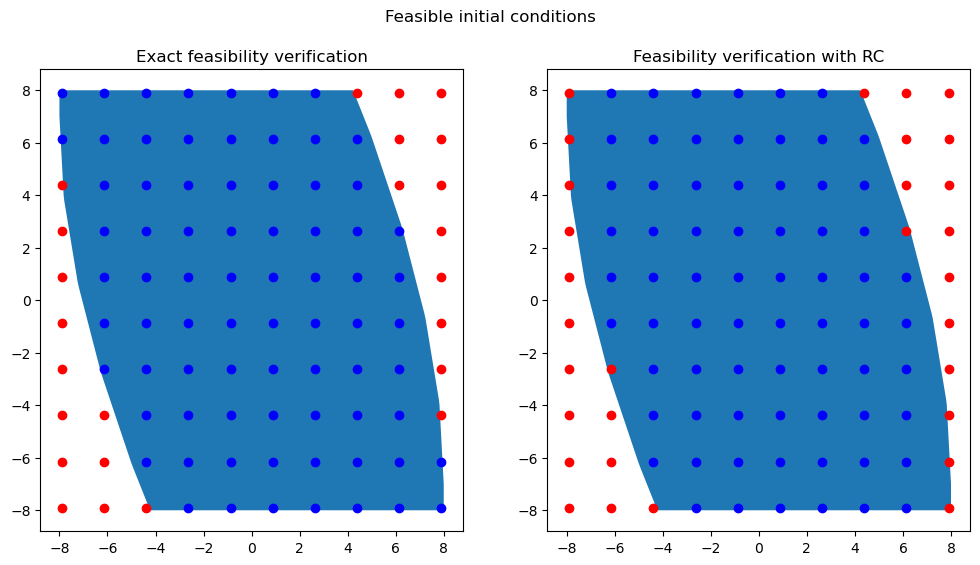

In [12]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharex=True,
                                    figsize=(12, 6))

fig.suptitle('Feasible initial conditions')
ax0.set_title('Exact feasibility verification')
ax1.set_title('Feasibility verification with RC')

# Plot the sets of feasible initial conditions in both subfigures
V = exactFeasibleSets[ind].V
arg = np.argsort(np.arctan2(V[:,0],V[:,1]))
V = np.vstack([V[arg,:],V[arg[0],:]])
ax0.fill(V[:,0],V[:,1])
ax1.fill(V[:,0],V[:,1])

# Plot the feasibility of the sampled initial conditions
for (i,xbar) in enumerate(feasible_xbar):
    ax0.plot(xbar[0],xbar[1], 'bo')
    if isinstance(feasible_nu[i], float) and feasible_nu[i] < 1e6:
        ax1.plot(xbar[0],xbar[1], 'bo')
    else:
        ax1.plot(xbar[0],xbar[1], 'ro')

for (i,xbar) in enumerate(infeasible_xbar):
    ax0.plot(xbar[0],xbar[1], 'ro')
    if isinstance(infeasible_nu[i], float) and infeasible_nu[i] < 1e6:
        ax1.plot(xbar[0],xbar[1], 'bo')
    else:
        ax1.plot(xbar[0],xbar[1], 'ro')

plt.show()

We should see that the initial conditions infeasible for $(\star\star)$ are concentrated around the boundary of the feasible region of $(\star)$ (the blue polytope).

Next, we carry out a larger simulation, series, where we go through the prediction horizons $N = 0,\ldots , 4$ and through the parameter values $\epsilon_A = 0.05 p$, $p = 1,\ldots , 9$.

Start simulations with prediction horizon 0


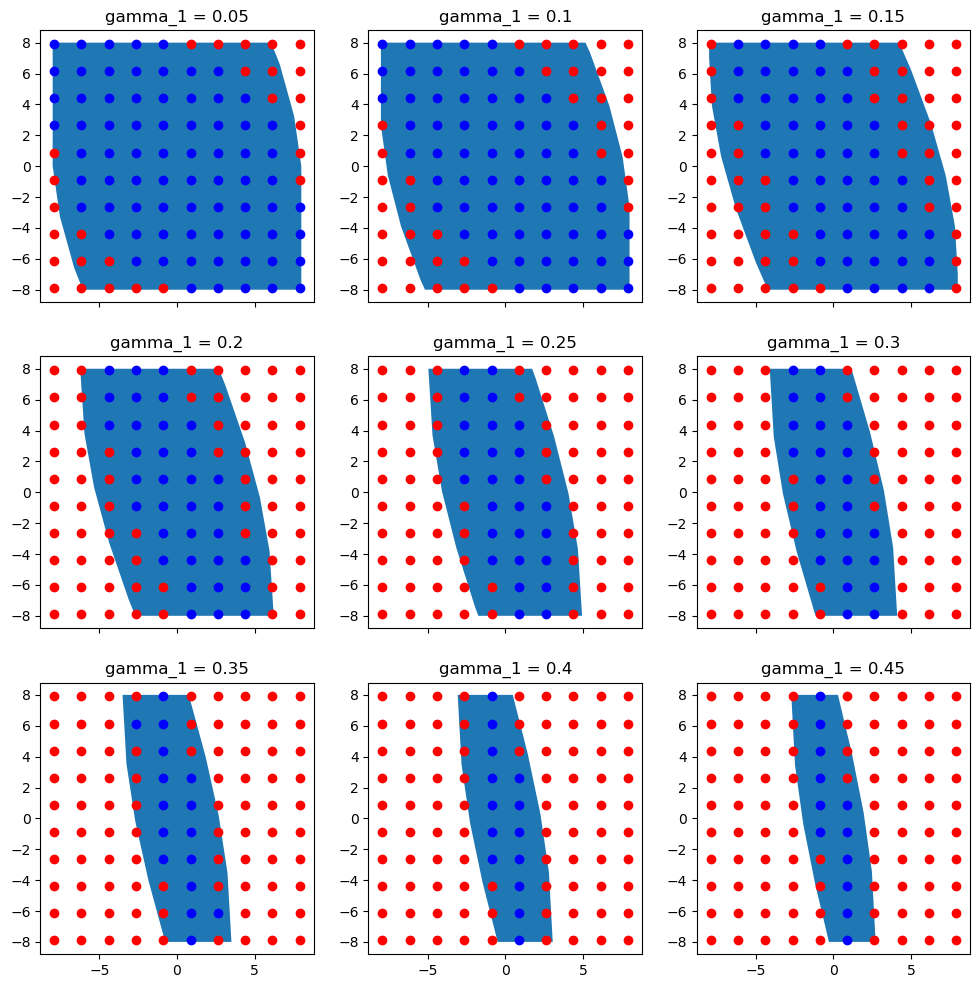

Start simulations with prediction horizon 1


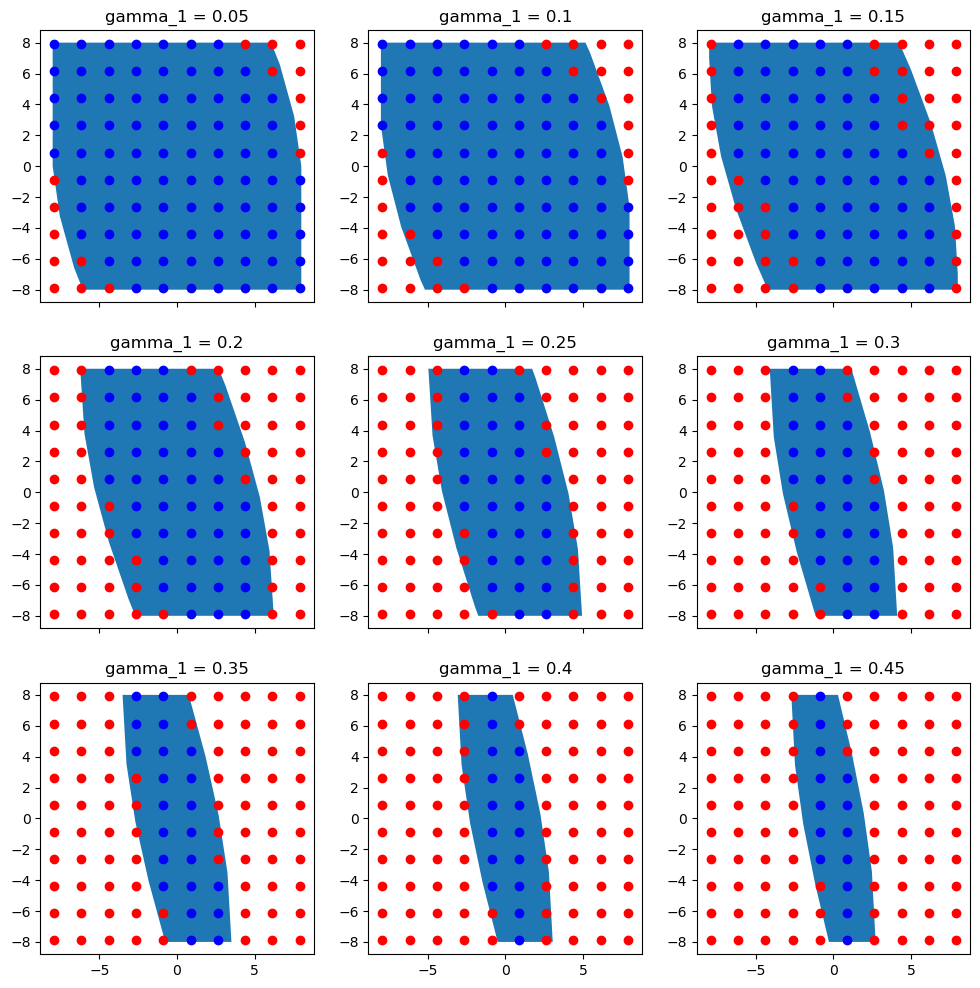

Start simulations with prediction horizon 2


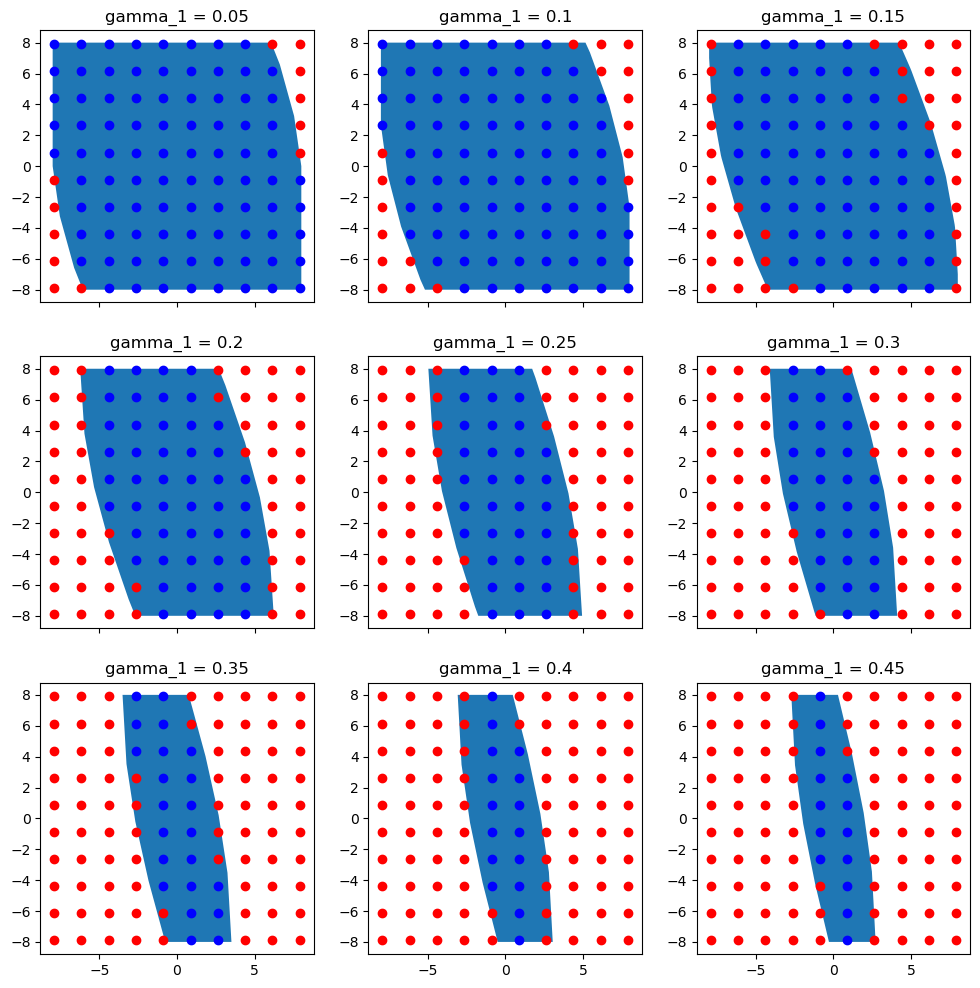

Start simulations with prediction horizon 3


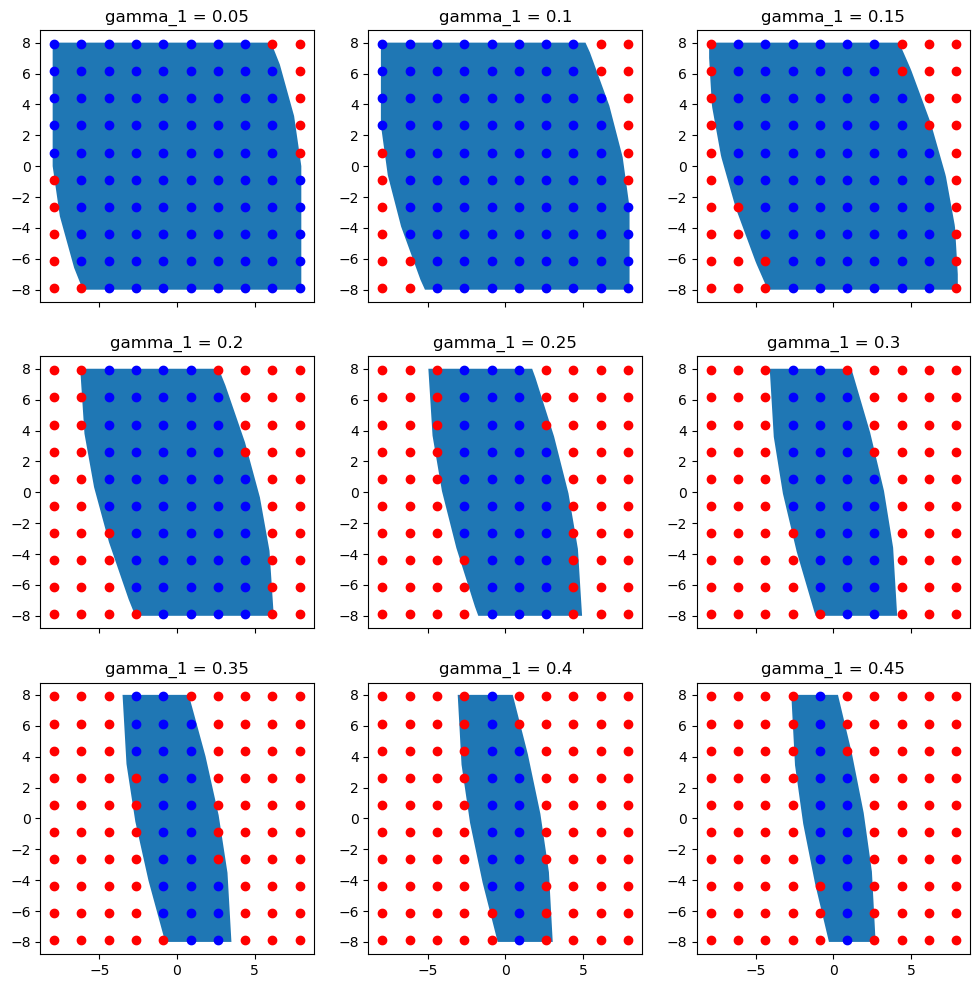

Start simulations with prediction horizon 4


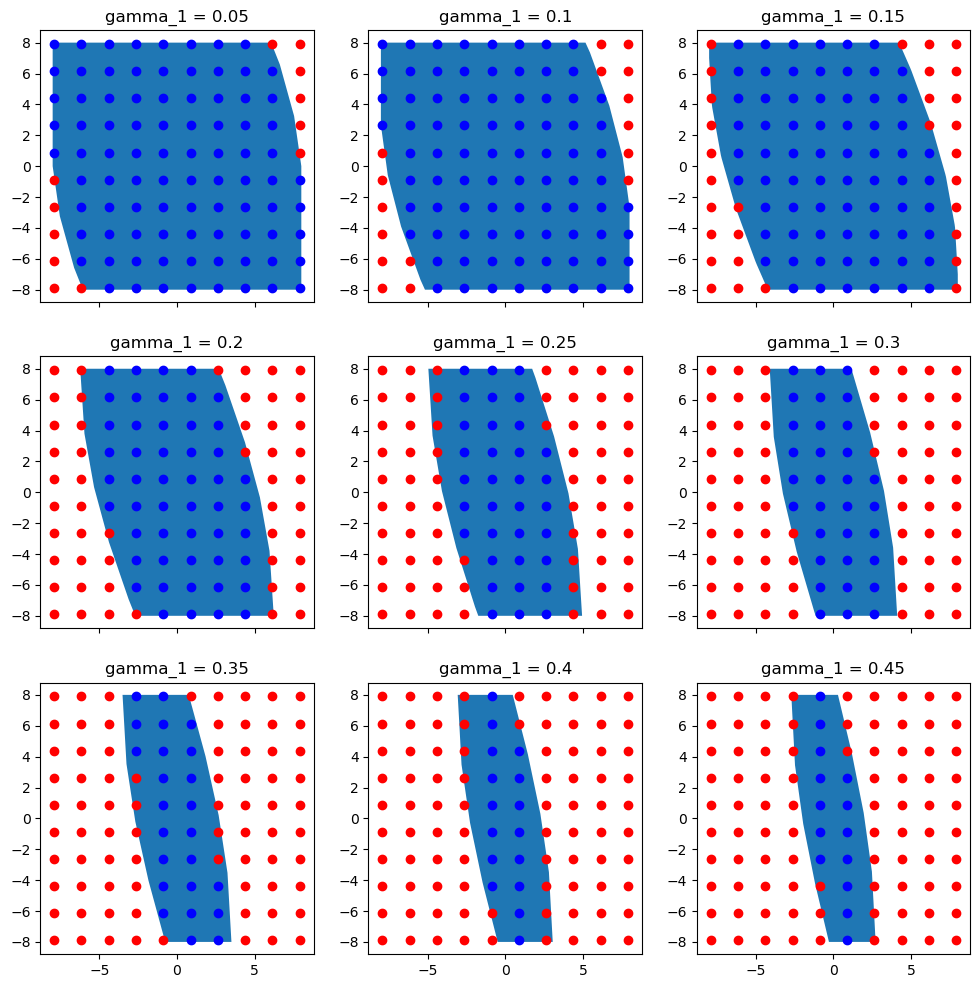

In [14]:
N_array = [0,1,2,3,4]
x1points = np.linspace(-7.9, 7.9, num=10)
x2points = np.linspace(-7.9, 7.9, num=10)

# Table storing the number of feasible initial conditions for each horizon N and each parameter eps_A
num_feas_Table = np.zeros((len(N_array),len(gamma1_array)))

for (j,N) in enumerate(N_array):
    print('Start simulations with prediction horizon {}'.format(N))
    fig, ax = plt.subplots(nrows=3, ncols=3, sharex=True,figsize=(12, 12))
    for (i,gamma1) in enumerate(gamma1_array):
        ax[i//3,i % 3].set_title('gamma_1 = {}'.format(gamma1))
        
        # Plot the exact feasible set
        V = exactFeasibleSets[i].V
        arg = np.argsort(np.arctan2(V[:,0],V[:,1]))
        V = np.vstack([V[arg,:],V[arg[0],:]])
        ax[i//3,i % 3].fill(V[:,0],V[:,1])
        for x1 in x1points:
            for x2 in x2points:
                xbar = np.array([[x1],[x2]])
                (f,A,B1,B2,g1,C1,D11,D12,g2,C2,D21,g3,C3,D31,D32,M,constraintsM) = initParameters(N,gamma1,gamma2)
                (K,P,nu) = infinite_horizon_uncertainty(xbar,f,A,B1,B2,g1,C1,D11,D12,g2,C2,D21,g3,C3,D31,D32,M,constraintsM)
                if isinstance(nu, float) and nu < 1e6:
                    ax[i//3,i % 3].plot(xbar[0],xbar[1], 'bo')
                    num_feas_Table[j,i] += 1
                else:
                    ax[i//3,i % 3].plot(xbar[0],xbar[1], 'ro')
    plt.show()
    fig.suptitle('Feasible initial conditions for horizon {}'.format(N))
    fig.savefig('coveringPlot_kf{}.png'.format(N))

We can plot the fraction of initial conditions feasible for $(\star\star)$ devided by the initial conditions feasible for $(\star)$ over the parameter $\gamma_1$. We should see that with a growing prediction horizon $N$, this fraction monotonically increases.

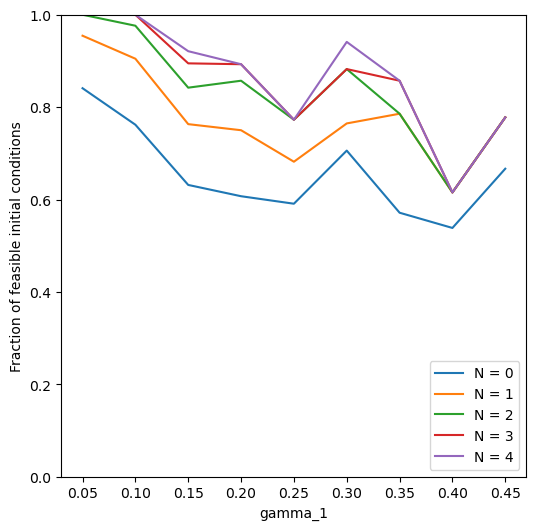

In [15]:
#import tikzplotlib

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True,figsize=(6, 6))

max_feas = np.zeros((len(gamma1_array),))
for (i,gamma1) in enumerate(gamma1_array):
    for x1 in x1points:
        for x2 in x2points:
            xbar = np.array([[x1],[x2]])
            if np.all(exactFeasibleSets[i].A @ xbar <= exactFeasibleSets[i].b):
                max_feas[i] += 1

for (j,N) in enumerate(N_array):
    ax.plot(gamma1_array,num_feas_Table[j,:]/max_feas)
    ax.set_xlabel('gamma_1')
    ax.set_ylabel('Fraction of feasible initial conditions')
plt.ylim([0.0,1.0])
plt.legend(['N = {}'.format(N) for N in N_array], loc ="lower right")

#tikzplotlib.save("coverageComparison.tex")